In [ ]:
# beem136_tb818_legal_aid_ew.ipynb
# Author: Thomas Burrows (tb818)
# Last edit: 20/11/2025, tb818

# SEE README FOR FULL DETAILS

# =====================================================================================
################## SECTION 1: CLEANING AND BALANCING PANELS ###########################
# =====================================================================================

# Cleans and balances panels required for analysis of civil legal aid provision in England and Wales.
# Datasets:
#   - Legal Aid Agency civil legal aid completions by provider area
#   - Census 2011 data for local authority districts in England and Wales (population, age, ethnicity, housing tenure, and economic activity)
#   - Census local authority district lookup data
#   - Converter from old to new local authority district codes
#   - Inflation data from ONS to convert nominal values to real terms (CPIH)

# Returns: full_panel.csv - cleaned and merged panel dataset for analysis

# SECTIONS:
# 1(A) - Initial setup, packages and data loading
# 1(B) - Initial panel construction
# 1(C) - Census and inflation data adding

# ============================== Setup =========================================
from pathlib import Path                        # For easier path reading
import pandas as pd                             # For data manipulation
import numpy as np                              # For numerical operations
import geopandas as gpd                         # For geospatial data manipulation
import matplotlib.pyplot as plt                 # For plotting
import seaborn as sns                           # For enhanced visualisations
import matplotlib as mpl                        # For custom plotting
import matplotlib.colors as mcolors             # For custom colour maps
import matplotlib.patches as mpatches           # For construction of data legends
import sys                                      # For functional commands

# ================================== 1(A) SETUP ==================================
# --- PATH SETUP --- EDIT HERE ONLY
project_root = Path("C:/Users/tb818/OneDrive - University of Exeter/Documents/MRes Year 1/BEEM136 - Research Methods/legal_aid")

# Do not edit from below - sub-paths standardised with / for cross-platform compatibility
raw_files_inputs = Path(project_root/"raw_data")
cleaned_files_outputs = Path(project_root/"cleaned_data")
summary_stats = Path(project_root/"graphics/summary_stats")
time_series = Path(project_root/"graphics/time_series")
unique_providers_maps = Path(project_root/"graphics/unique_providers_maps")
deserts_maps = Path(project_root/"graphics/deserts_maps")
violin_dist = Path(project_root/"graphics/violins")

# Loads raw data
print("Loading data...")
provider_data_raw = pd.read_csv(raw_files_inputs / "legal-aid-statistics-civil-completions-provider-area-data-to-mar-2024.csv")

# To inspect raw data
# print(provider_data_completed_raw.info())

# ================================== 1(B) INITIAL PANEL CONSTRUCTION ==================================
# Constructs the panel by work completed
# Outputs by LA x quarter: total volume of cases, total value of cases, and total unique providers

# QUARTER MAPPING
# For conversion of financial year to calendar years
FQ_TO_CAL_Q = {1: 2, 2: 3, 3: 4, 4: 1}

# --- INITIAL CLEANING ---
print("Cleaning data...")
clean_data = (
    provider_data_raw
      # Keeping only needed columns; improves code efficiency
      [["VOL", "Total Value", "Fin_YR", "FIN_QTR", "LACode", "firm_code"]]
      .rename(
          columns={
              "VOL": "volume",
              "Total Value": "value",
              "Fin_YR": "fy",
              "FIN_QTR": "fq",
              "LACode": "lacode"}))

# Vectorised cleaning using Pandas - value, years and quarters cleaned to numeric
clean_data["value"] = pd.to_numeric(clean_data["value"], errors="coerce")
clean_data["fy_start"] = pd.to_numeric(clean_data["fy"].astype(str).str[:4], errors="coerce")
clean_data["fq"] = pd.to_numeric(clean_data["fq"], errors="coerce")

# Conversion of financial to calendar year
cal_q = clean_data["fq"].map(FQ_TO_CAL_Q)
cal_year = clean_data["fy_start"] + (clean_data["fq"] == 4).astype(int)
clean_data["year_quarter"] = cal_year.astype(int).astype(str) + "-q" + cal_q.astype(int).astype(str)

# --- LA × QUARTER TOTALS ---
print("Computing LA totals...")
# Aggregates totals for local authorities, by year_quarter
completed_la_totals = (
    clean_data
      .groupby(["year_quarter", "lacode"], as_index=False)
      .agg(
          la_total_volume=("volume", "sum"),
          la_total_value=("value", "sum"),
          unique_providers=("firm_code", "nunique")))

# --- NATIONAL TOTALS PER QUARTER ---
print("Computing national totals...")
# Aggregates totals by year_quarter only (i.e. national totals)
quarterly_totals = (
    clean_data
      .groupby("year_quarter", as_index=False)
      .agg(
          total_volume=("volume", "sum"),
          total_value=("value", "sum"),
          total_unique_providers=("firm_code", "nunique")))

# --- LA LOOKUP (E & W only) ---
print("Loading LA lookup file...")
# Ensuring all local authorities codes contained using authoritative guide
la_lookup = pd.read_csv(
    raw_files_inputs / "Local_Authority_District_(2022)_to_Local_Authority_District_(2023)_Lookup_for_EW.csv")

# Filtering ONS lookup to only England and Wales to fit with scope of panel
print("Filtering to England and Wales...")
la_lookup_filtered = (
    la_lookup
      .loc[la_lookup["LAD23CD"].str.startswith(("E", "W")), ["LAD23CD", "LAD23NM"]]
      .drop_duplicates(subset="LAD23CD")
      .rename(columns={"LAD23CD": "lacode", "LAD23NM": "localauthority"})
      .reset_index(drop=True))

# --- BALANCED PANEL INDEX ---
print("Constructing empty panel...")
# To balance, an empty LACODE*YR_QTR panel is created as a blank panel, filled with available data,
# and then 0 imputed for missing data
all_quarters = (
    completed_la_totals["year_quarter"]
      .astype(str)
      .sort_values()
      .unique())

all_las = (
    la_lookup_filtered["lacode"]
      .astype(str)
      .sort_values()
      .unique())

# The complete (empty) panel
idx = pd.MultiIndex.from_product(
    [all_quarters, all_las],
    names=["year_quarter", "lacode"])

balanced_panel = (
    completed_la_totals
      .set_index(["year_quarter", "lacode"])
      .reindex(idx)
      .reset_index())

# Filling missing aggregates with zero
balanced_panel[["la_total_volume", "la_total_value", "unique_providers"]] = (
    balanced_panel[["la_total_volume", "la_total_value", "unique_providers"]].fillna(0))

# Merging LA names
balanced_panel = balanced_panel.merge(
    la_lookup_filtered,
    on="lacode",
    how="left")

# Merging quarterly totals
balanced_panel = balanced_panel.merge(
    quarterly_totals,
    on="year_quarter",
    how="left")

# Trimming data from 2010-Q1 to 2019-Q4
balanced_panel = balanced_panel.loc[
    (balanced_panel["year_quarter"] >= "2010-q1")
    & (balanced_panel["year_quarter"] <= "2019-q4")
].reset_index(drop=True)

# ================================== 1(C) ADDING CENSUS AND INFLATION DATA ==================================
# This section cleans the 5 census datasets for use in analysis
# Each cleaning process is analogous, so only population is fully commented
# Where additional notes are necessary, these are provided in-line

# Builds a dictionary for code mapping, old to new
print("Loading census data...")
converter = pd.read_csv(raw_files_inputs / "census_la_converter.csv")
code_map = dict(zip(converter["Old"], converter["New"]))

# POPULATION
# Reading raw population data
census_raw_population = pd.read_csv(raw_files_inputs / "raw_census_2011_populations.csv")

# Initial cleaning function
print("Cleaning population data...")
census_clean_population = (
    census_raw_population
    # renaming geography code to lacode for consistency
    .rename(columns={"geography code": "lacode"})
    # Dropping unneeded columns
    .drop(columns=[
        "date",
        "geography",
        "Rural Urban",
        "Variable: Area (Hectares); measures: Value",
        "Variable: Density (number of persons per hectare); measures: Value",
        "Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value"]))
# Any relevant LA codes mapped to new codes
census_clean_population["lacode"] = census_clean_population["lacode"].replace(code_map)

# Selecting target columns
target_cols_pop = [
  "Variable: All usual residents; measures: Value",
  "Variable: Males; measures: Value",
  "Variable: Females; measures: Value",
  "Variable: Lives in a household; measures: Value",
  "Variable: Lives in a communal establishment; measures: Value"]

# Filtering to target columns only (and lacode)
census_clean_population = census_clean_population.loc[:, ["lacode"] + target_cols_pop].rename(columns={
    "Variable: All usual residents; measures: Value": "residents_total",
    "Variable: Males; measures: Value": "males_total",
    "Variable: Females; measures: Value": "females_total",
    "Variable: Lives in a household; measures: Value": "household_dwellers",
    "Variable: Lives in a communal establishment; measures: Value": "communal_dwellers"})

# Aggregates for updated LAs
census_clean_population = census_clean_population.groupby("lacode", as_index=False).sum(numeric_only=True)

# AGES
census_raw_ages = pd.read_csv(raw_files_inputs / "raw_census_2011_ages.csv")

print("Cleaning age data...")
census_clean_age = (
    census_raw_ages
    .rename(columns={"geography code": "lacode"})
    .drop(columns=[
        "date",
        "geography",
        "Rural Urban",
        "Age: All usual residents; measures: Value",
        "Age: Mean Age; measures: Value",
        "Age: Median Age; measures: Value"]))
census_clean_age["lacode"] = census_clean_age["lacode"].replace(code_map)

target_cols_age = [
  "Age: Age 0 to 4; measures: Value",
  "Age: Age 5 to 7; measures: Value",
  "Age: Age 8 to 9; measures: Value",
  "Age: Age 10 to 14; measures: Value",
  "Age: Age 15; measures: Value",
  "Age: Age 16 to 17; measures: Value",
  "Age: Age 18 to 19; measures: Value",
  "Age: Age 20 to 24; measures: Value",
  "Age: Age 25 to 29; measures: Value",
  "Age: Age 30 to 44; measures: Value",
  "Age: Age 45 to 59; measures: Value",
  "Age: Age 60 to 64; measures: Value",
  "Age: Age 65 to 74; measures: Value",
  "Age: Age 75 to 84; measures: Value",
  "Age: Age 85 to 89; measures: Value",
  "Age: Age 90 and over; measures: Value"]

census_clean_age = census_clean_age.loc[:,["lacode"] + target_cols_age].rename(columns={
    "Age: Age 0 to 4; measures: Value": "total_0_4",
    "Age: Age 5 to 7; measures: Value": "total_5_7",
    "Age: Age 8 to 9; measures: Value": "total_8_9",
    "Age: Age 10 to 14; measures: Value": "total_10_14",
    "Age: Age 15; measures: Value": "total_15",
    "Age: Age 16 to 17; measures: Value": "total_16_17",
    "Age: Age 18 to 19; measures: Value": "total_18_19",
    "Age: Age 20 to 24; measures: Value": "total_20_24",
    "Age: Age 25 to 29; measures: Value": "total_25_29",
    "Age: Age 30 to 44; measures: Value": "total_30_44",
    "Age: Age 45 to 59; measures: Value": "total_45_59",
    "Age: Age 60 to 64; measures: Value": "total_60_64",
    "Age: Age 65 to 74; measures: Value": "total_65_74",
    "Age: Age 75 to 84; measures: Value": "total_75_84",
    "Age: Age 85 to 89; measures: Value": "total_85_89",
    "Age: Age 90 and over; measures: Value": "total_90_over"})

census_clean_age = census_clean_age.groupby("lacode", as_index=False).sum(numeric_only=True)

# Constructing age groupings for analysis
census_clean_age = census_clean_age.assign(
    working_age = census_clean_age[[
        "total_16_17","total_18_19","total_20_24","total_25_29",
        "total_30_44","total_45_59","total_60_64","total_65_74"
    ]].sum(axis=1, min_count=1),
    children = census_clean_age[[
        "total_0_4","total_5_7","total_8_9","total_10_14","total_15"
    ]].sum(axis=1, min_count=1),
    pensioner = census_clean_age[[
        "total_75_84","total_85_89","total_90_over"
    ]].sum(axis=1, min_count=1))

# EMPLOYMENT
census_raw_employment = pd.read_csv(raw_files_inputs / "raw_census_2011_economic_activity.csv")

print("Cleaning employment data...")
census_clean_employment = (
    census_raw_employment
    .rename(columns={"geography code": "lacode"})
    .drop(columns=[
        "date",
        "geography",
        "Economic Activity: All usual residents aged 16 to 74; measures: Value"]))
census_clean_employment["lacode"] = census_clean_employment["lacode"].replace(code_map)

# N.B. Filtering to England and Wales only. Not necessary for all census datasets (not all available at same level of analysis)
census_clean_employment = census_clean_employment[census_clean_employment["lacode"].str.startswith(("E","W"))]

target_cols_employment = [
  "Economic Activity: Economically active; measures: Value",
  "Economic Activity: Economically active: In employment; measures: Value",
  "Economic Activity: Economically active: Employee: Part-time; measures: Value",
  "Economic Activity: Economically active: Employee: Full-time; measures: Value",
  "Economic Activity: Economically active: Self-employed; measures: Value",
  "Economic Activity: Economically active: Unemployed; measures: Value",
  "Economic Activity: Economically active: Full-time student; measures: Value",
  "Economic Activity: Economically Inactive; measures: Value",
  "Economic Activity: Economically inactive: Retired; measures: Value",
  "Economic Activity: Economically inactive: Student (including full-time students); measures: Value",
  "Economic Activity: Economically inactive: Looking after home or family; measures: Value",
  "Economic Activity: Economically inactive: Long-term sick or disabled; measures: Value",
  "Economic Activity: Economically inactive: Other; measures: Value",
  "Economic Activity: Unemployed: Age 16 to 24; measures: Value",
  "Economic Activity: Unemployed: Age 50 to 74; measures: Value",
  "Economic Activity: Unemployed: Never worked; measures: Value",
  "Economic Activity: Long-term unemployed; measures: Value"]

census_clean_employment = census_clean_employment.loc[:, ["lacode"] + target_cols_employment].rename(columns={
    "Economic Activity: Economically active; measures: Value": "econ_active",
    "Economic Activity: Economically active: In employment; measures: Value": "a_employed",
    "Economic Activity: Economically active: Employee: Part-time; measures: Value": "a_part_time",
    "Economic Activity: Economically active: Employee: Full-time; measures: Value": "a_full_time",
    "Economic Activity: Economically active: Self-employed; measures: Value": "a_self_employed",
    "Economic Activity: Economically active: Unemployed; measures: Value": "a_unemployed",
    "Economic Activity: Economically active: Full-time student; measures: Value": "a_student",
    "Economic Activity: Economically Inactive; measures: Value": "econ_inactive",
    "Economic Activity: Economically inactive: Retired; measures: Value": "ia_retired",
    "Economic Activity: Economically inactive: Student (including full-time students); measures: Value": "ia_student",
    "Economic Activity: Economically inactive: Looking after home or family; measures: Value": "ia_carer",
    "Economic Activity: Economically inactive: Long-term sick or disabled; measures: Value": "ia_sick_disb",
    "Economic Activity: Economically inactive: Other; measures: Value": "ina_other",
    "Economic Activity: Unemployed: Age 16 to 24; measures: Value": "unemployed_16_24",
    "Economic Activity: Unemployed: Age 50 to 74; measures: Value": "unemployed_50_74",
    "Economic Activity: Unemployed: Never worked; measures: Value": "unemployed_forever",
    "Economic Activity: Long-term unemployed; measures: Value": "unemployed_lt"})

census_clean_employment = census_clean_employment.groupby("lacode", as_index=False).sum(numeric_only=True)

# Calculating unemployment rate
census_clean_employment["unemployment_rate"] = census_clean_employment["a_unemployed"] / census_clean_employment["econ_active"]

# HOUSING
census_raw_tenure = pd.read_csv(raw_files_inputs / "raw_census_2011_housing_tenure.csv")

print("Cleaning housing data...")
census_clean_tenure = (
    census_raw_tenure
    .rename(columns={"geography code": "lacode"})
    .drop(columns=["date", "geography", "Rural Urban"]))
census_clean_tenure["lacode"] = census_clean_tenure["lacode"].replace(code_map)
census_clean_tenure = census_clean_tenure[census_clean_tenure["lacode"].str.startswith(("E","W"))]

target_cols_tenure = [
  "Tenure: All households; measures: Value",
  "Tenure: Owned; measures: Value",
  "Tenure: Owned: Owned outright; measures: Value",
  "Tenure: Owned: Owned with a mortgage or loan; measures: Value",
  "Tenure: Shared ownership (part owned and part rented); measures: Value",
  "Tenure: Social rented; measures: Value",
  "Tenure: Social rented: Rented from council (Local Authority); measures: Value",
  "Tenure: Social rented: Other; measures: Value",
  "Tenure: Private rented; measures: Value",
  "Tenure: Private rented: Private landlord or letting agency; measures: Value",
  "Tenure: Private rented: Other; measures: Value",
  "Tenure: Living rent free; measures: Value"]

census_clean_tenure = census_clean_tenure.loc[:, ["lacode"] + target_cols_tenure].rename(columns={
    "Tenure: All households; measures: Value": "households",
    "Tenure: Owned; measures: Value": "hh_owned",
    "Tenure: Owned: Owned outright; measures: Value": "hh_owned_outright",
    "Tenure: Owned: Owned with a mortgage or loan; measures: Value": "hh_owned_mortgaged",
    "Tenure: Shared ownership (part owned and part rented); measures: Value": "hh_shared_own",
    "Tenure: Social rented; measures: Value": "hh_social_rented",
    "Tenure: Social rented: Rented from council (Local Authority); measures: Value": "hh_social_rented_council",
    "Tenure: Social rented: Other; measures: Value": "hh_social_rented_other",
    "Tenure: Private rented; measures: Value": "hh_private_rented",
    "Tenure: Private rented: Private landlord or letting agency; measures: Value": "hh_private_rented_landlord",
    "Tenure: Private rented: Other; measures: Value": "hh_private_rented_other",
    "Tenure: Living rent free; measures: Value": "hh_rent_free"})
census_clean_tenure = census_clean_tenure.groupby("lacode", as_index=False).sum(numeric_only=True)

# Calculating proportions
census_clean_tenure = census_clean_tenure.assign(
    prop_hh_owned = census_clean_tenure["hh_owned"] / census_clean_tenure["households"],
    prop_hh_social_rented = census_clean_tenure["hh_social_rented"] / census_clean_tenure["households"],
    prop_hh_private_rented = census_clean_tenure["hh_private_rented"] / census_clean_tenure["households"],
    prop_hh_rented = (census_clean_tenure["hh_social_rented"] + census_clean_tenure["hh_private_rented"]) / census_clean_tenure["households"])

# ETHNICITY
census_raw_ethnicity = pd.read_csv(raw_files_inputs / "raw_census_2011_ethnicity.csv")

print("Cleaning ethnicity data...")
census_clean_ethnicity = (
    census_raw_ethnicity
    .rename(columns={"geography code": "lacode"})
    .drop(columns=["date","geography","Rural Urban"]))
census_clean_ethnicity["lacode"] = census_clean_ethnicity["lacode"].replace(code_map)
census_clean_ethnicity = census_clean_ethnicity[census_clean_ethnicity["lacode"].str.startswith(("E","W"))]

target_cols_ethnicity = [
  "Ethnic Group: All usual residents; measures: Value",
  "Ethnic Group: White; measures: Value",
  "Ethnic Group: White: English/Welsh/Scottish/Northern Irish/British; measures: Value",
  "Ethnic Group: White: Irish; measures: Value",
  "Ethnic Group: White: Gypsy or Irish Traveller; measures: Value",
  "Ethnic Group: White: Other White; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups: White and Black Caribbean; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups: White and Black African; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups: White and Asian; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups: Other Mixed; measures: Value",
  "Ethnic Group: Asian/Asian British; measures: Value",
  "Ethnic Group: Asian/Asian British: Indian; measures: Value",
  "Ethnic Group: Asian/Asian British: Pakistani; measures: Value",
  "Ethnic Group: Asian/Asian British: Bangladeshi; measures: Value",
  "Ethnic Group: Asian/Asian British: Chinese; measures: Value",
  "Ethnic Group: Asian/Asian British: Other Asian; measures: Value",
  "Ethnic Group: Black/African/Caribbean/Black British; measures: Value",
  "Ethnic Group: Black/African/Caribbean/Black British: African; measures: Value",
  "Ethnic Group: Black/African/Caribbean/Black British: Caribbean; measures: Value",
  "Ethnic Group: Black/African/Caribbean/Black British: Other Black; measures: Value",
  "Ethnic Group: Other ethnic group; measures: Value",
  "Ethnic Group: Other ethnic group: Arab; measures: Value",
  "Ethnic Group: Other ethnic group: Any other ethnic group; measures: Value"]

census_clean_ethnicity = census_clean_ethnicity.loc[:, ["lacode"] + target_cols_ethnicity].rename(columns={
    "Ethnic Group: All usual residents; measures: Value": "residents",
    "Ethnic Group: White; measures: Value": "eth_white",
    "Ethnic Group: White: English/Welsh/Scottish/Northern Irish/British; measures: Value": "eth_white_brit",
    "Ethnic Group: White: Irish; measures: Value": "eth_white_irish",
    "Ethnic Group: White: Gypsy or Irish Traveller; measures: Value": "eth_white_trav",
    "Ethnic Group: White: Other White; measures: Value": "eth_white_other",
    "Ethnic Group: Mixed/multiple ethnic groups; measures: Value": "eth_mixed",
    "Ethnic Group: Mixed/multiple ethnic groups: White and Black Caribbean; measures: Value": "eth_mixed_carrib",
    "Ethnic Group: Mixed/multiple ethnic groups: White and Black African; measures: Value": "eth_mixed_afr",
    "Ethnic Group: Mixed/multiple ethnic groups: White and Asian; measures: Value": "eth_mixed_asian",
    "Ethnic Group: Mixed/multiple ethnic groups: Other Mixed; measures: Value": "eth_mixed_other",
    "Ethnic Group: Asian/Asian British; measures: Value": "eth_asian",
    "Ethnic Group: Asian/Asian British: Indian; measures: Value": "eth_asian_ind",
    "Ethnic Group: Asian/Asian British: Pakistani; measures: Value": "eth_asian_pak",
    "Ethnic Group: Asian/Asian British: Bangladeshi; measures: Value": "eth_asian_bang",
    "Ethnic Group: Asian/Asian British: Chinese; measures: Value": "eth_asian_chi",
    "Ethnic Group: Asian/Asian British: Other Asian; measures: Value": "eth_asian_other",
    "Ethnic Group: Black/African/Caribbean/Black British; measures: Value": "eth_black",
    "Ethnic Group: Black/African/Caribbean/Black British: African; measures: Value": "eth_black_afr",
    "Ethnic Group: Black/African/Caribbean/Black British: Caribbean; measures: Value": "eth_black_carrib",
    "Ethnic Group: Black/African/Caribbean/Black British: Other Black; measures: Value": "eth_black_other",
    "Ethnic Group: Other ethnic group; measures: Value": "eth_other",
    "Ethnic Group: Other ethnic group: Arab; measures: Value": "eth_other_arab",
    "Ethnic Group: Other ethnic group: Any other ethnic group; measures: Value": "eth_other_other"})
census_clean_ethnicity = census_clean_ethnicity.groupby("lacode", as_index=False).sum(numeric_only=True)

# Calculating proportions
census_clean_ethnicity = census_clean_ethnicity.assign(
    prop_eth_white = census_clean_ethnicity["eth_white"] / census_clean_ethnicity["residents"],
    prop_eth_mixed = census_clean_ethnicity["eth_mixed"] / census_clean_ethnicity["residents"],
    prop_eth_asian = census_clean_ethnicity["eth_asian"] / census_clean_ethnicity["residents"],
    prop_eth_black = census_clean_ethnicity["eth_black"] / census_clean_ethnicity["residents"],
    prop_eth_other = census_clean_ethnicity["eth_other"] / census_clean_ethnicity["residents"])

# COMBINED
print("Combining census data...")
census_data = (
    census_clean_population
    .merge(census_clean_age, on="lacode", how="outer")
    .merge(census_clean_employment, on="lacode", how="outer")
    .merge(census_clean_tenure, on="lacode", how="outer")
    .merge(census_clean_ethnicity, on="lacode", how="outer"))
census_data = census_data.loc[:, ~census_data.columns.duplicated(keep="first")]

# CENSUS DATA CHECKS
print("Checking census data...")
# Checking the union of LACODES with the panel:
codes_provider = set(balanced_panel["lacode"].astype("string"))
codes_census_population = set(census_clean_population["lacode"].astype("string"))
codes_census_age = set(census_clean_age["lacode"].astype("string"))
codes_census_employment = set(census_clean_employment["lacode"].astype("string"))
codes_census_tenure = set(census_clean_tenure["lacode"].astype("string"))
codes_census_ethnicity = set(census_clean_ethnicity["lacode"].astype("string"))
codes_census = set(census_data["lacode"].astype("string"))
all_equal = (
    codes_provider
    == codes_census_population
    == codes_census_age
    == codes_census_employment
    == codes_census_tenure
    == codes_census_ethnicity
    == codes_census)
print("All code sets identical across provider + all census tables:", all_equal)

# Checking for any missing values in the census data
missing_rows = census_data.isna().any(axis=1).sum()
print(f"Rows in census data with any missing values: {missing_rows} out of {len(census_data)}")

# Checking that all proportion columns are between 0 and 1
proportion_cols = [col for col in census_data.columns if col.startswith("prop_")]
for col in proportion_cols:
    if not ((census_data[col] >= 0) & (census_data[col] <= 1)).all():
        print(f"Proportion column {col} has values outside the range [0, 1].")
if not (census_data[unemployment_rate := "unemployment_rate"] >= 0).all() or not (census_data[unemployment_rate] <= 1).all():
    print(f"Proportion column {unemployment_rate} has values outside the range [0, 1].")

# Constructing the full panel by merging balanced_panel with census_data
print("Combining panel with census data...")
full_panel = balanced_panel.merge(census_data, on="lacode", how="left")

### INFLATION ADJUSTMENT
# Loading inflation data
print("Loading inflation data...")
inflation_data = pd.read_csv(raw_files_inputs / "inflation_data.csv")

# Merging inflation index onto full_panel (1:m by year_quarter)
full_panel = full_panel.merge(
    inflation_data[["year_quarter", "index_15"]],
    on="year_quarter",
    how="left")

# Checking inflation values for all time periods
missing_inf = full_panel.loc[full_panel["index_15"].isna(), "year_quarter"].unique()
print("Year_quarter values in full_panel missing inflation data:",missing_inf)

# Create adjusted value columns
full_panel["adjusted_la_total_value"] = (full_panel["la_total_value"] * full_panel["index_15"])
full_panel["adjusted_total_value"] = (full_panel["total_value"] * full_panel["index_15"])

# Creating volume-rval index (aggregate and per LA)
full_panel["val_vol"] = (full_panel["adjusted_total_value"] / full_panel["total_volume"])
full_panel["la_val_vol"] = (full_panel["adjusted_la_total_value"] / full_panel["la_total_volume"])

# Building rebased indices (2012-q4 = 100)
# This is the first period where LASPO reforms are fully in effect
full_panel["volume_index"] = (full_panel["total_volume"]/full_panel.loc[full_panel["year_quarter"] == "2012-q4", "total_volume"].iloc[0] * 100)
full_panel["value_index"] = (full_panel["adjusted_total_value"]/full_panel.loc[full_panel["year_quarter"] == "2012-q4", "adjusted_total_value"]
                        .iloc[0] * 100)
full_panel["cases_index"] = (full_panel["val_vol"] / full_panel.loc[full_panel["year_quarter"] == "2012-q4", "val_vol"]
                        .iloc[0] * 100)

# Legal aid deserts: proportion of local authorities and populations within them
prop_zero = (full_panel.groupby("year_quarter").apply(lambda d: (d["unique_providers"] == 0).sum() / d["lacode"].nunique()).reset_index(name="prop_zero"))
pop_zero = (full_panel.loc[full_panel["unique_providers"] == 0].groupby("year_quarter")["residents_total"].sum().reset_index(name="pop_zero"))
full_panel = full_panel.merge(prop_zero, on="year_quarter", how="left")
full_panel = full_panel.merge(pop_zero, on="year_quarter", how="left")

# SAVING
full_panel.to_csv(cleaned_files_outputs / "full_panel.csv", index=False)
print("Panel saved to full_panel.csv")

Loading data...


C:\Users\tb818\AppData\Local\Temp\ipykernel_25104\726946883.py:54: DtypeWarning: Columns (7,8,10,25) have mixed types. Specify dtype option on import or set low_memory=False.
  provider_data_raw = pd.read_csv(raw_files_inputs / "legal-aid-statistics-civil-completions-provider-area-data-to-mar-2024.csv")


Cleaning data...
Computing LA totals...
Computing national totals...
Loading LA lookup file...
Filtering to England and Wales...
Constructing empty panel...
Loading census data...
Cleaning population data...
Cleaning age data...
Cleaning employment data...
Cleaning housing data...
Cleaning ethnicity data...
Combining census data...
Checking census data...
All code sets identical across provider + all census tables: True
Rows in census data with any missing values: 0 out of 318
Combining panel with census data...
Loading inflation data...
Year_quarter values in full_panel missing inflation data: []


C:\Users\tb818\AppData\Local\Temp\ipykernel_25104\726946883.py:550: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prop_zero = (full_panel.groupby("year_quarter").apply(lambda d: (d["unique_providers"] == 0).sum() / d["lacode"].nunique()).reset_index(name="prop_zero"))


Panel saved to full_panel.csv


                                  mean        median
adjusted_la_total_value  734203.423109  385545.77714
la_total_volume             433.688915     193.00000
unique_providers              8.430818       6.00000
                                  mean        median
adjusted_la_total_value  295584.252804  233981.38878
la_total_volume             153.417060     104.00000
unique_providers              4.795131       4.00000

Most frequently occurring local authorities (Top 10):
   lacode      localauthority  Value  Volume  Firms  Mentions
E08000025          Birmingham     37      15     40        92
E09000007              Camden     32      14     16        62
E09000033         Westminster      6       6     22        34
E08000003          Manchester      7       3     11        21
E08000019           Sheffield      1      12      0        13
E08000021 Newcastle upon Tyne      0      12      0        12
E09000001      City of London      8       0      1         9
E08000012           Liver

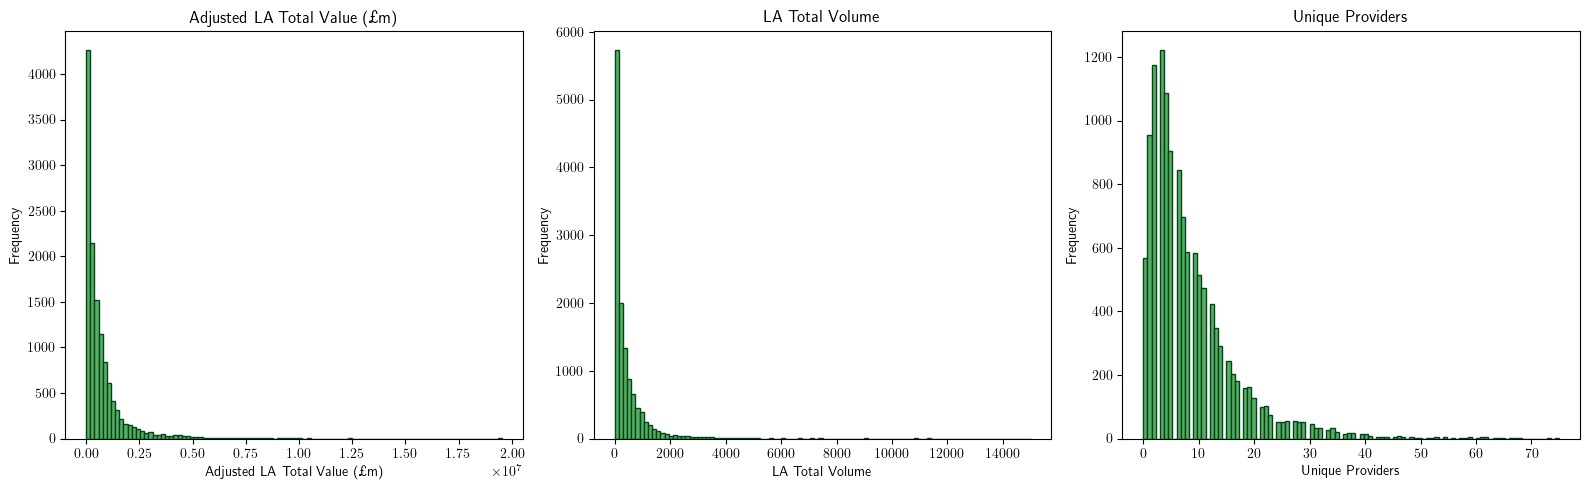

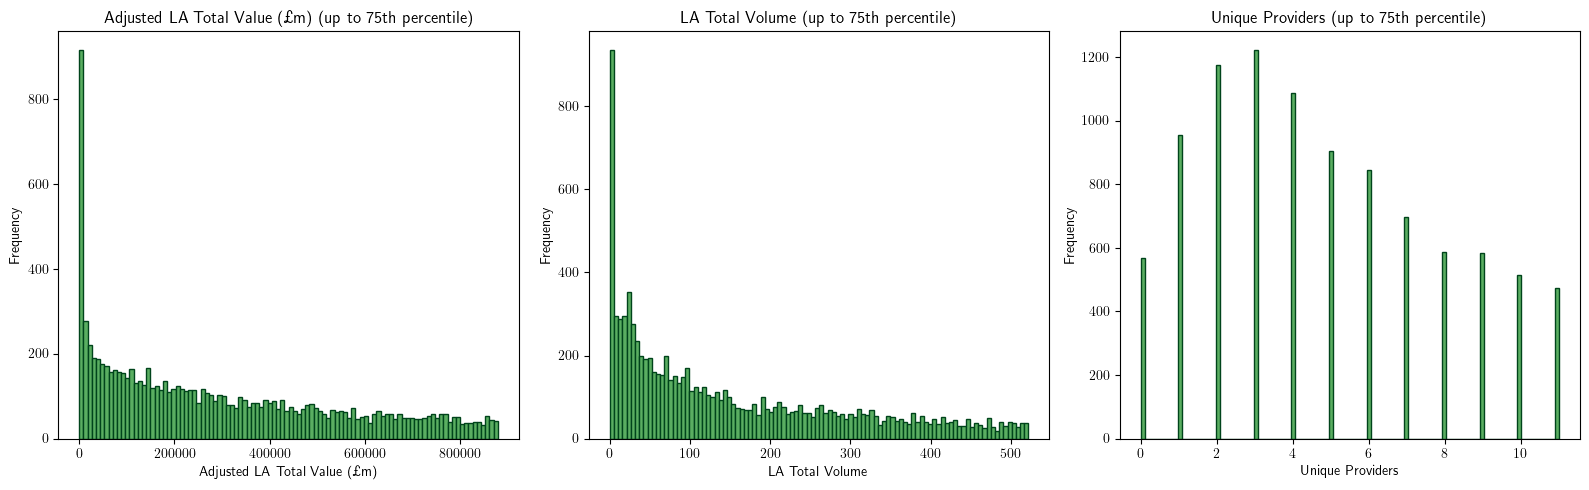

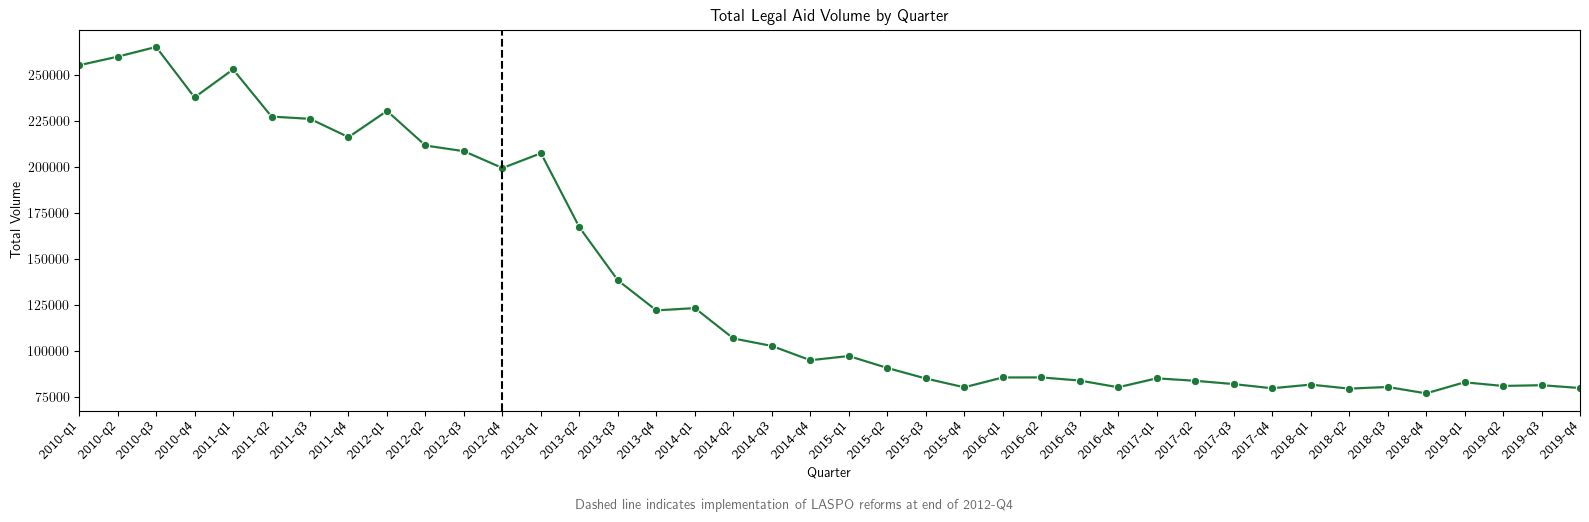

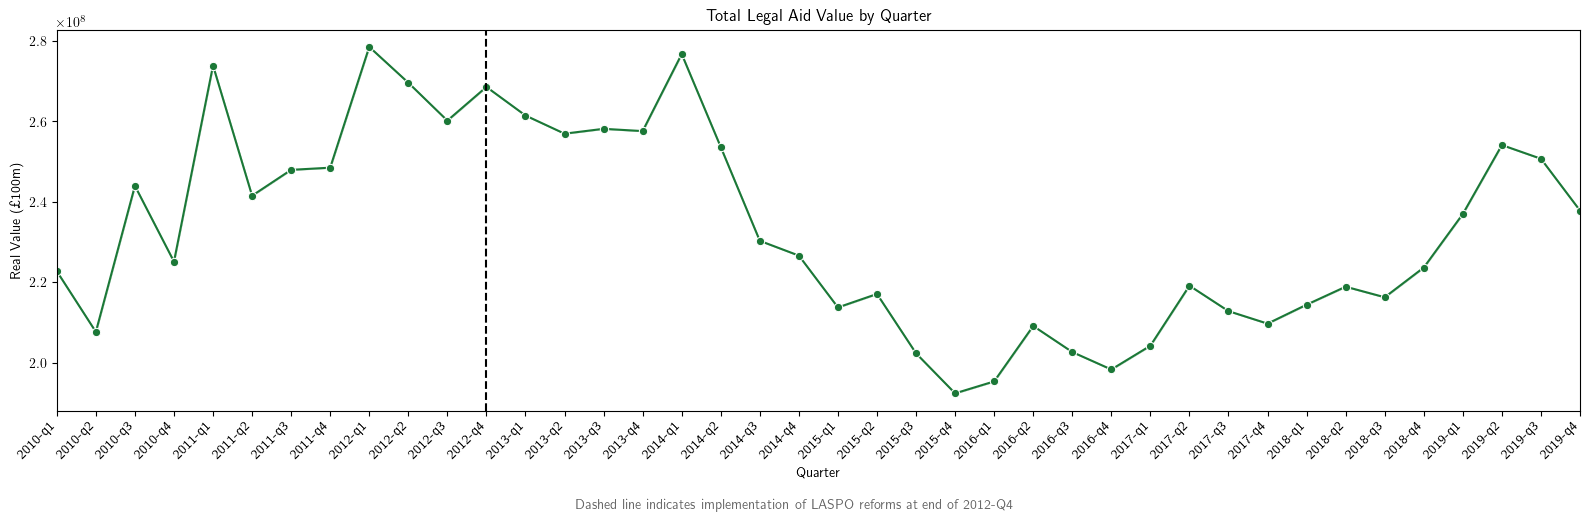

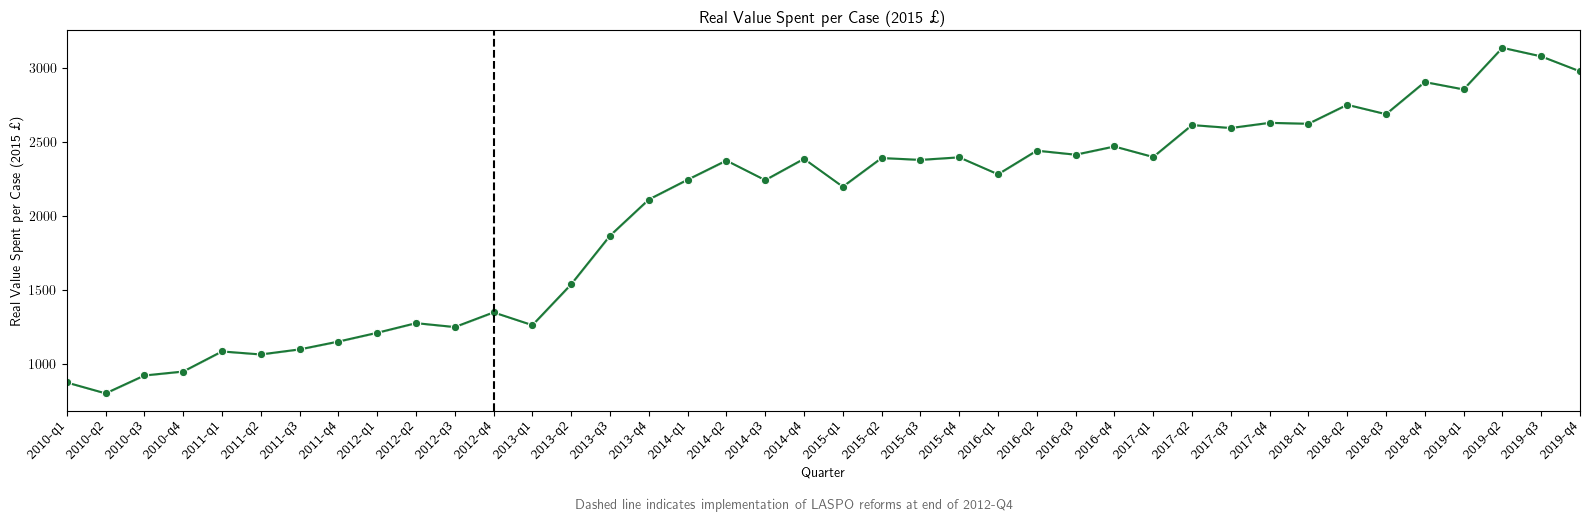

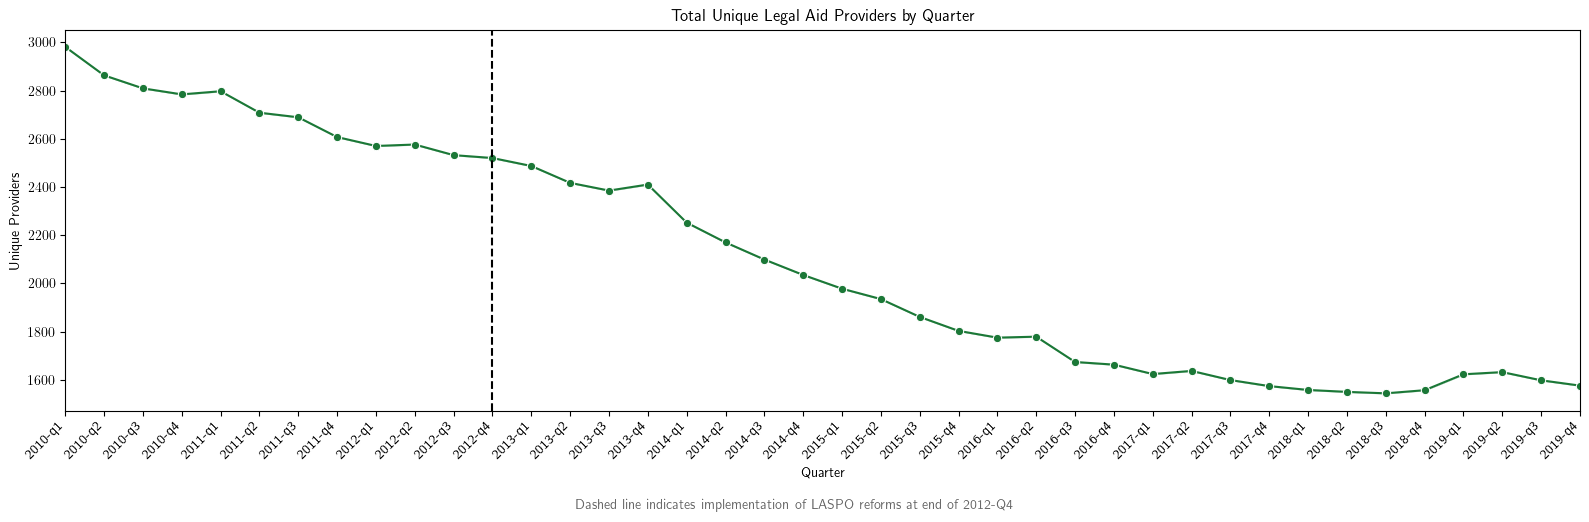

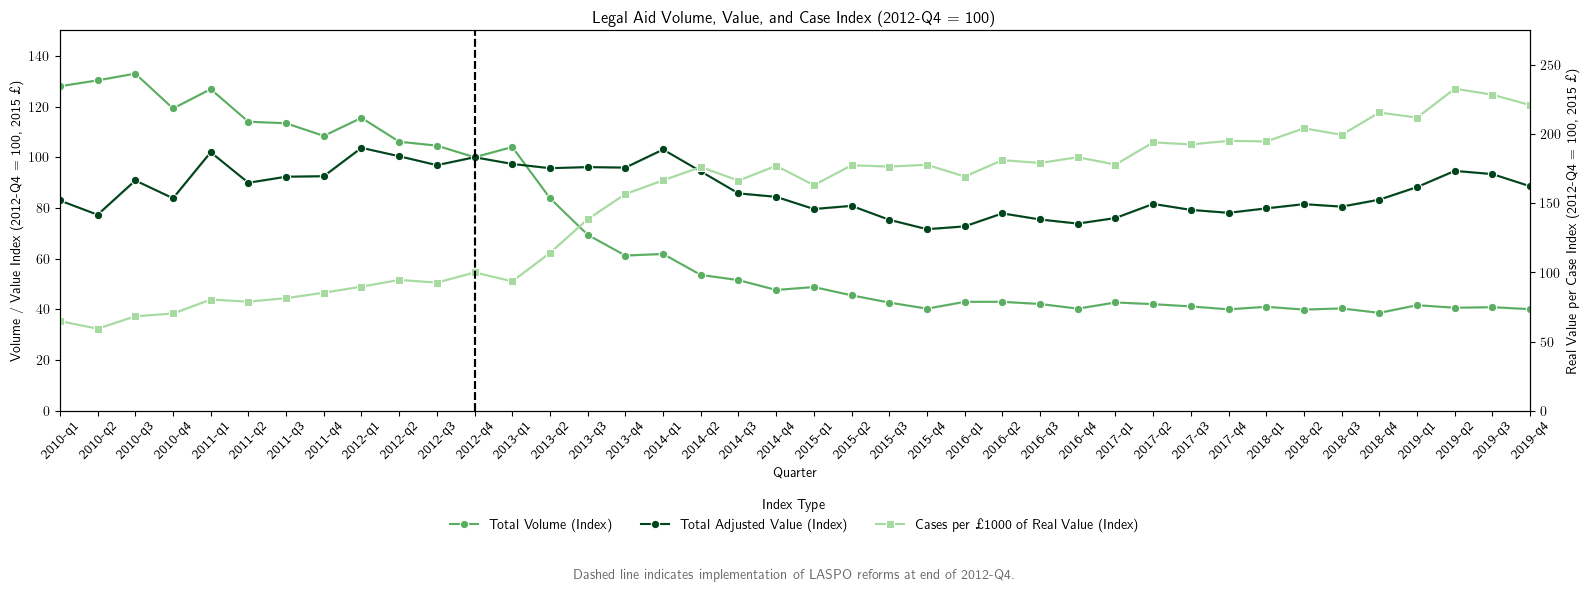

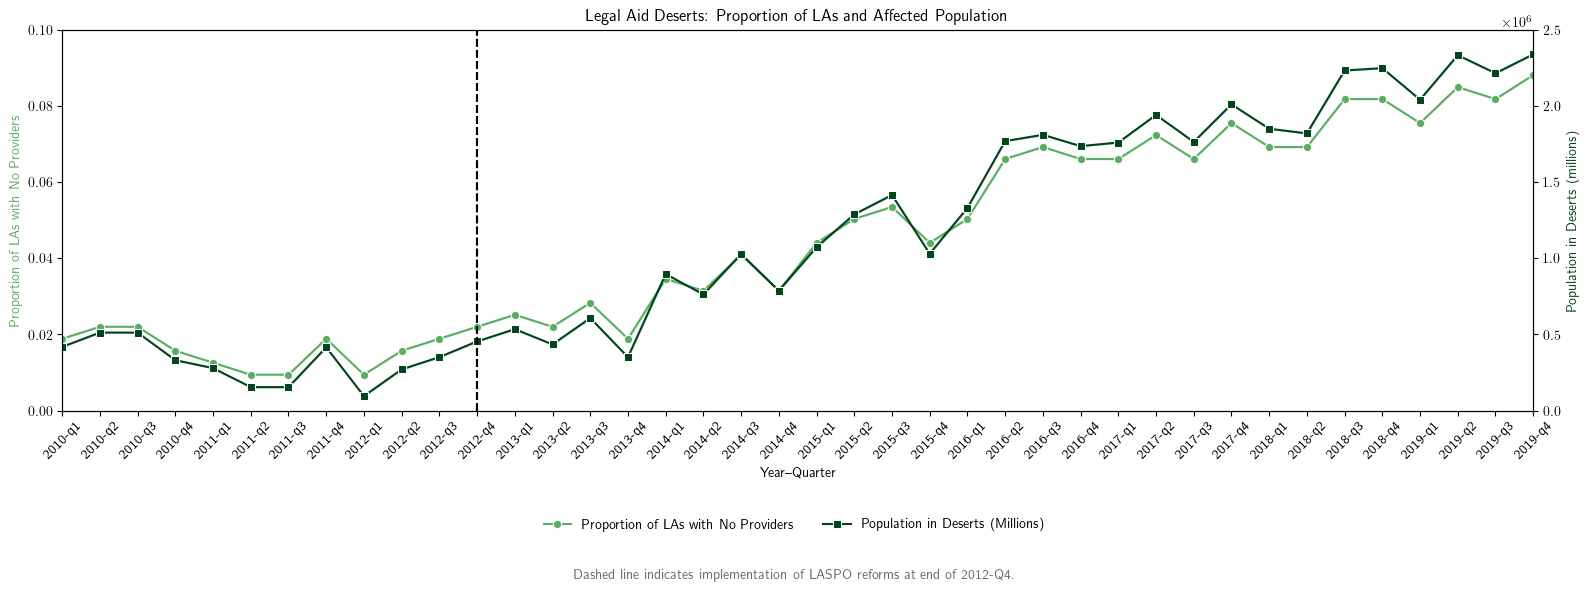

In [4]:
# =====================================================================================
############# SECTION 2: SUMMARY STATISTICS AND DATA VISUALISATION ####################
# =====================================================================================
# This section displays summary statistics for the cleaned data and creates visualisations of legal aid provision trends over time

# SECTIONS:
# 2(A) - Summary Statistics
# 2(B) - Time Series
# 2(C) - Maps
# 2(D) - Violin Distributions

# NOTE: this code assumes that the provider panel has already been cleaned and saved as full_panel.csv
# Whilst this section can be run independently of most of Section 1, running Section 1a is required for used packages

# Loading cleaned provider panel data as vs_panel for clarity that it is being used for visualisation
vs_panel = pd.read_csv(cleaned_files_outputs/"full_panel.csv")

# Standardised colour setup dictionary
exeter_greens = {
    "light": "#d9f0d3",
    "light_medium": "#a6dba0",
    "medium": "#5aae61",
    "medium_dark": "#1b7837",
    "dark": "#00441b"}

### ------------------------------------- 2(A): SUMMARY STATISTICS ------------------------------------###
# Basic summary statistics
cols = ["adjusted_la_total_value", "la_total_volume", "unique_providers"]
titles = ["Adjusted LA Total Value (£m)", "LA Total Volume", "Unique Providers"]

# Aggregating for simple mean and median
summary = vs_panel[cols].agg(["mean", "median"]).T
print(summary)

# Using matplotlib to plot distributions of value, volume and unique provider counts
# They are then saved to the same PDF
plt.figure(figsize=(16, 5))
for i, (col, title) in enumerate(zip(cols, titles), start=1):
    plt.subplot(1, 3, i)
    plt.hist(full_panel[col], bins=100, color=exeter_greens["medium"], edgecolor=exeter_greens["dark"])
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig(summary_stats / "val_vol_providers_dist.pdf", bbox_inches="tight", transparent=True, format="pdf")

# As data strongly positively skewed, displaying only first 75%
# Computing trimmed versions per variable for first 3 quartiles
trimmed = {}
for col in cols:
    cutoff = vs_panel[col].quantile(0.75)
    trimmed[col] = vs_panel.loc[vs_panel[col] <= cutoff, col]

# Summary stats for the first 3 quartiles (i.e. bottom 75%)
to_75_pct_summary = pd.DataFrame({col: [trimmed[col].mean(), trimmed[col].median()] for col in cols}, index=["mean", "median"]).T
print(to_75_pct_summary)

# Plotting histograms and saving
plt.figure(figsize=(16, 5))
for i, (col, title) in enumerate(zip(cols, titles), start=1):
    plt.subplot(1, 3, i)
    plt.hist(trimmed[col], bins=100, color=exeter_greens["medium"], edgecolor=exeter_greens["dark"])
    plt.title(f"{title} (up to 75th percentile)")
    plt.xlabel(title)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig(summary_stats / "val_vol_providers_dist_75pc.pdf", bbox_inches="tight", transparent=True, format="pdf")

## Most frequently highest LAs for value, volume and unique providers (firms)
# Function to count
def top_lacodes(df, col, n=100):
    top = df.nlargest(n, col)
    return top["lacode"].value_counts()

# Counting appearances among top 100s
top_value = top_lacodes(vs_panel, "adjusted_la_total_value")
top_volume = top_lacodes(vs_panel, "la_total_volume")
top_providers = top_lacodes(vs_panel, "unique_providers")

# Combining results
top_summary = pd.concat(
    [top_value, top_volume, top_providers],
    axis=1,
    keys=["Value", "Volume", "Firms"]).fillna(0).astype(int)

# Adding total mentions
top_summary["Mentions"] = top_summary.sum(axis=1)
top_summary = top_summary.sort_values("Mentions", ascending=False).reset_index().rename(columns={"index": "lacode"})

# Merging back to get local authority names
las_summary_stats = vs_panel[["lacode", "localauthority"]].drop_duplicates()
top_summary = top_summary.merge(las_summary_stats, on="lacode", how="left")

# Reordering for display
top_summary = top_summary[["lacode", "localauthority", "Value", "Volume", "Firms", "Mentions"]]

# Displaying top 10
print("\nMost frequently occurring local authorities (Top 10):")
print(top_summary.head(10).to_string(index=False))

# Displays maximum values for each
print("\n--- Highest adjusted value ---")
print(full_panel.loc[full_panel["adjusted_la_total_value"].idxmax(),
                     ["year_quarter", "lacode", "localauthority", "adjusted_la_total_value"]])

print("\n--- Highest total volume ---")
print(full_panel.loc[full_panel["la_total_volume"].idxmax(),
                     ["year_quarter", "lacode", "localauthority", "la_total_volume"]])

print("\n--- Highest unique providers ---")
print(full_panel.loc[full_panel["unique_providers"].idxmax(),
                     ["year_quarter", "lacode", "localauthority", "unique_providers"]])

### ------------------------------------------ SECTION 2B: TIME SERIES ------------------------------------------------ ###
## Total Legal Aid Volume by Quarter ##
# Plotting time series of volume, value, index of cases per £1000, and unique firm count to see patterns in data
# Using seaborn/matplotlib. All plots equivalently generated; only first commented for explanation
plt.figure(figsize=(16, 5))
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="total_volume",
    marker="o",
    color=exeter_greens["medium_dark"])

plt.title("Total Legal Aid Volume by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Total Volume")
plt.xticks(rotation=45, ha="right")

# Add vertical line at period of LASPO implementation
plt.axvline(x="2012-q4", linestyle="--", color="black")

# Limiting x-axis to actual data range (aesthetic)
x_values = vs_panel["year_quarter"].unique()
plt.xlim(x_values.min(), x_values.max())

# LASPO line caption
plt.figtext(0.5, -0.01,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4",
    ha="center", va="top", fontsize=10, color="dimgray")

# Saving
plt.tight_layout()
plt.savefig(time_series / "vol_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

## Total Legal Aid Value by Quarter ##
plt.figure(figsize=(16, 5))
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="adjusted_total_value",
    marker="o",
    color=exeter_greens["medium_dark"])

plt.title("Total Legal Aid Value by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Real Value (£100m)")
plt.xticks(rotation=45, ha="right")

plt.axvline(x="2012-q4", linestyle="--", color="black")

x_values = vs_panel["year_quarter"].unique()
plt.xlim(x_values.min(), x_values.max())

plt.figtext(
    0.5, -0.01,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4",
    ha="center", va="top", fontsize=10, color="dimgray")

plt.tight_layout()
plt.savefig(time_series / "adj_val_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

## Total Value/Volume Index by Quarter ##
plt.figure(figsize=(16, 5))

sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="val_vol",
    marker="o",
    color=exeter_greens["medium_dark"])

plt.title("Real Value Spent per Case (2015 £)")
plt.xlabel("Quarter")
plt.ylabel("Real Value Spent per Case (2015 £)")
plt.xticks(rotation=45, ha="right")

plt.axvline(x="2012-q4", linestyle="--", color="black")

x_values = vs_panel["year_quarter"].unique()
plt.xlim(x_values.min(), x_values.max())

plt.figtext(
    0.5, -0.01,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4",
    ha="center", va="top", fontsize=10, color="dimgray")

plt.tight_layout()
plt.savefig(time_series / "val_vol_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

## Unique Firms by Quarter ##
plt.figure(figsize=(16, 5))
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="total_unique_providers",
    marker="o",
    color=exeter_greens["medium_dark"])

plt.title("Total Unique Legal Aid Providers by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Unique Providers")

plt.xticks(rotation=45, ha="right")

plt.axvline(x="2012-q4", linestyle="--", color="black")

x_values = vs_panel["year_quarter"].unique()
plt.xlim(x_values.min(), x_values.max())

plt.figtext(
    0.5, -0.01,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4",
    ha="center", va="top", fontsize=10, color="dimgray")

plt.tight_layout()
plt.savefig(time_series / "unique_firms_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

## Total Legal Aid Indices by Quarter ##
fig, ax1 = plt.subplots(figsize=(16, 5))
ax2 = ax1.twinx()

# Plotting: Volume
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="volume_index",
    marker="o",
    color=exeter_greens["medium"],
    label="Total Volume (Index)",
    ax=ax1)

# Plotting: Value
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="value_index",
    marker="o",
    color=exeter_greens["dark"],
    label="Total Adjusted Value (Index)",
    ax=ax1)

# Plotting: Cases
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="cases_index",
    marker="s",
    color=exeter_greens["light_medium"],
    label="Cases per £1000 of Real Value (Index)",
    ax=ax2)

# Left y-axis (0–150): Scale for Total Volume and Total Adjusted Value
ax1.set_ylabel("Volume / Value Index (2012-Q4 = 100, 2015 £)")
ax1.set_ylim(0, 150)
ax1.set_xlabel("Quarter")
ax1.tick_params(axis="x", rotation=45)

# Right y-axis (0–275): Scale for Real Value per Case
ax2.set_ylabel("Real Value per Case Index (2012-Q4 = 100, 2015 £)")
ax2.set_ylim(0, 275)

# Matching x-axis to data range
x_values = vs_panel["year_quarter"].unique()
ax1.set_xlim(x_values.min(), x_values.max())

# LASPO vertical line
for ax in [ax1, ax2]:
    ax.axvline(x="2012-q4", linestyle="--", color="black")

# Removing legends from individual axes (aesthetic)
if ax1.get_legend():
    ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()

# Combined legend below (aesthetic)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.1),
    title="Index Type")

# Title and caption
plt.title("Legal Aid Volume, Value, and Case Index (2012-Q4 = 100)")
fig.text(
    0.5,
    -0.15,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4.",
    ha="center",
    va="top",
    fontsize=10,
    color="dimgray")

# Saving
plt.tight_layout()
plt.savefig(time_series / "val_vol_cases_indexes_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

## Total Proportion of and Population in Legal Aid Deserts ##
fig, ax1 = plt.subplots(figsize=(16, 5))
ax2 = ax1.twinx()

# Plotting: Proportion of LAs with no providers
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="prop_zero",
    marker="o",
    color=exeter_greens["medium"],
    ax=ax1,
    label="Proportion of LAs with No Providers")

# Plotting: Population in deserts
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="pop_zero",
    marker="s",
    color=exeter_greens["dark"],
    ax=ax2,
    label="Population in Deserts (Millions)")

# Left y-axis: proportion of deserts
ax1.set_ylabel("Proportion of LAs with No Providers", color=exeter_greens["medium"])
ax1.set_xlabel("Year–Quarter")
ax1.set_title("Legal Aid Deserts: Proportion of LAs and Affected Population")
ax1.tick_params(axis="x", rotation=45)
ax1.set_ylim(0, 0.1)

# Right y-axis: population in deserts, millions
ax2.set_ylabel("Population in Deserts (millions)", color=exeter_greens["dark"])
ax2.set_ylim(0, 2.5e6)

# X-axis limits to data range
x_values = vs_panel["year_quarter"].unique()
ax1.set_xlim(x_values.min(), x_values.max())

# LASPO line
for ax in [ax1, ax2]:
    ax.axvline(x="2012-q4", linestyle="--", color="black")

# Remove legends on axes (aesthetic)
if ax1.get_legend():
    ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()

# Combined legend below (aesthetic)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc="lower center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, -0.1))

fig.text(
    0.5,
    -0.15,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4.",
    ha="center",
    va="top",
    fontsize=10,
    color="dimgray")

# Saving
plt.tight_layout()
plt.savefig(time_series / "deserts_prop_pop.pdf", bbox_inches="tight", transparent=True, format="pdf")

print("Time series graphs completed.")

### ---------------------------------------------- SECTION 2C: MAPS ------------------------------------------------------ ###
# Colour maps for geographical visualisation, using custom green gradient for Exeter branding
order = ["light", "light_medium", "medium", "medium_dark", "dark"]
exeter_cmap = mcolors.LinearSegmentedColormap.from_list(
    "exeter_greens",
    [exeter_greens[k] for k in order])

# Loading shapefile and dropping Scottish and NI codes
shp = gpd.read_file(raw_files_inputs / "LAD_DEC_2023_UK_BFC.shp")
shp = shp.loc[~shp["LAD23CD"].str.startswith(("N", "S"))]

# Checking for code mismatch, and interrupting loop if found
code_diff = ((set(shp["LAD23CD"].unique())) ^ (set(vs_panel["lacode"].unique())))
if code_diff:
    print("LA code mismatch")
    sys.exit("Terminating")

# Compute global range for consistent colour scaling, so that all maps use same scale
global_min = vs_panel["unique_providers"].min()
global_max = vs_panel["unique_providers"].max()

# Looping through all quarters in the panel
for q in sorted(vs_panel["year_quarter"].unique()):
    # Data from the quarter
    data_q = vs_panel.loc[vs_panel["year_quarter"] == q, ["lacode", "unique_providers"]]
    # Merged with shapefile by lacode=LAD23CD
    merged = shp.merge(data_q, left_on="LAD23CD", right_on="lacode", how="left")

    # Plotting one graph per year_quarter
    fig, ax = plt.subplots(figsize=(8, 10))
    merged.plot(
        column="unique_providers",
        cmap=exeter_cmap,
        linewidth=0.1,
        edgecolor="black",
        legend=False,
        vmin=global_min,
        vmax=global_max,
        ax=ax)

    # Titling and transparent background
    ax.set_title(f"Unique Providers per Local Authority, {q}", fontsize=10)
    ax.axis("off")
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")
    plt.tight_layout()

    # Saving as vectorised image
    fig.savefig(unique_providers_maps / f"unique_providers_{q}.pdf", bbox_inches="tight", transparent=True, format="pdf")
    plt.close(fig)

# Saving colour scale legend separately
fig, ax = plt.subplots(figsize=(6, 0.6))
fig.patch.set_alpha(0)
norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)

cbar = mpl.colorbar.ColorbarBase(
    ax,
    cmap=exeter_cmap,
    norm=norm,
    orientation="horizontal")

cbar.set_label("Unique Providers per Local Authority", fontsize=10)
cbar.ax.tick_params(labelsize=8)

cbar.outline.set_visible(False)

plt.savefig(unique_providers_maps / "unique_providers_colour_scale.pdf", bbox_inches="tight", transparent=True, format="pdf")
plt.close(fig)

print("All maps and legend scale saved.")

# Dark green for deserts, white otherwise - 
desert_cmap = mcolors.ListedColormap(["#ffffff", "#00441b"])

# Looping through all quarters in the panel
for q in sorted(vs_panel["year_quarter"].unique()):
    # Data from the quarter
    data_q = vs_panel.loc[vs_panel["year_quarter"] == q, ["lacode", "unique_providers"]]

    # Merge with shapefile by lacode = LAD23CD
    merged = shp.merge(data_q, left_on="LAD23CD", right_on="lacode", how="left")

    # Binary flag: 1 = desert (unique_providers == 0), 0 = not desert
    merged["desert_flag"] = np.where(merged["unique_providers"] == 0, 1, 0)
    desert_count = int(merged["desert_flag"].sum())

    # Plotting one graph per year_quarter
    fig, ax = plt.subplots(figsize=(8, 10))
    merged.plot(
        column="desert_flag",
        cmap=desert_cmap,
        linewidth=0.1,
        edgecolor="black",
        legend=False,
        vmin=0,
        vmax=1,
        ax=ax)

    # Title and transparent background
    ax.set_title(
        f"Legal Aid Deserts (no unique providers), {q}\n"
        f"Total: {desert_count}",
        fontsize=10)
    ax.axis("off")
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")
    plt.tight_layout()

    # Save as vectorised image
    fig.savefig(
        deserts_maps / f"desert_map_{q}.pdf",
        bbox_inches="tight",
        transparent=True,
        format="pdf")
    plt.close(fig)

# Separate legend for deserts vs non-deserts
fig, ax = plt.subplots(figsize=(3, 1))
fig.patch.set_alpha(0)
ax.axis("off")

desert_patch = mpatches.Patch(
    facecolor="#00441b",
    edgecolor="black",
    linewidth=0.5,
    label="Legal Aid Desert (no unique providers)")

non_desert_patch = mpatches.Patch(
    facecolor="#ffffff",
    edgecolor="black",
    linewidth=0.5,
    label="Non-desert (unique providers)")

ax.legend(
    handles=[desert_patch, non_desert_patch],
    loc="center",
    frameon=False)

# Saving deserts colour scheme legend
plt.tight_layout()
fig.savefig(
    deserts_maps / "deserts_colour_scale.pdf",
    bbox_inches="tight",
    transparent=True,
    format="pdf")

plt.close(fig)

print("All desert maps and legend saved.")

### ---------------------------------------------- SECTION 2D: VIOLINS ---------------------------------------------------------------- ###
# Setting up violins requiring plotting in dictionary
violin = {
    "unique_providers": "Number of Unique Providers per LA",
    "la_total_volume": "Total Volume of Cases per LA",
    "adjusted_la_total_value": "Adjusted Total Value of Cases per LA (£m)",
    "la_val_vol": "Value-to-Volume Ratio per LA"}

# Plots a violin for each in the dictionary. Again custom greens used
# Relevant filtering so only unique values displayed
for var, label in violin.items():
    plt.figure(figsize=(18, 6))
    sns.violinplot(
        data=vs_panel,
        x="year_quarter",
        y=var,
        color=exeter_greens["medium"],
        order=vs_panel["year_quarter"].unique(),
        inner="quartile",
        density_norm="width",
        # So that display ends with data:
        cut=0)

    # Using function to add specific title
    plt.title(f"Distribution of {label} by Quarter")
    plt.xlabel("Year–Quarter")
    plt.ylabel(label)

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Saving
    plt.savefig(violin_dist / f"violin_{var}_by_quarter.pdf", bbox_inches="tight", format="pdf")
    plt.close()

# Filtering to 4 periods in data evenly spread, including first and last, for more meaningful display
period_subset = ["2010-q1", "2013-q2", "2016-q3", "2019-q4"]
vs_subset = (vs_panel[vs_panel["year_quarter"].isin(period_subset)])

for var, label in violin.items():
    plt.figure(figsize=(18, 6))
    sns.violinplot(
        data=vs_subset,
        x="year_quarter",
        y=var,
        color=exeter_greens["medium"],
        order=period_subset,
        inner="quartile",
        density_norm="width",
        cut=0)

    plt.title(f"Distribution of {label} by Quarter")
    plt.xlabel("Year–Quarter")
    plt.ylabel(label)

    # Limits visible y-axis for volume and val/vol index for easier interpretation
    if var == "la_total_volume":
        plt.ylim(0, 6000)
    elif var == "la_val_vol":
        plt.ylim(0, 40000)

    plt.xticks()
    plt.tight_layout()

    plt.savefig(violin_dist / f"subset_violin_{var}_by_quarter.pdf", bbox_inches="tight", format="pdf")
    plt.close()

print("Violins saved.")

In [ ]:
# =====================================================================================
######################### SECTION 3: STATISTICAL ANALYSIS #############################
# =====================================================================================